# Imports

In [ ]:
!pip install transformers
!pip install datasets
!pip install sentencepiece
!pip install scikit-learn-extra

     |████████████████████████████████| 1.9MB 8.4MB/s 
     |████████████████████████████████| 3.2MB 52.4MB/s 
     |████████████████████████████████| 890kB 56.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=2adb44edc9cdfd5304ad2b9ee2fe8560c9038314551f3becd7eeee0a2c6b4018
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 194kB 7.7MB/s 
     |████████████████████████████████| 245kB 13.0MB/s 
     |████████████████████████████████| 112kB 12.7MB/s 
     |████████████████████████████████| 1.2MB 8.3MB/s 
     |████████████████████████████████| 624kB 8.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp37-cp37m-linux_x86_64.whl size=339929 sha256=7c34381b7

In [ ]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import argparse
from __future__ import print_function
from collections import Counter
import string
import re
import argparse
import json
import os
import random
import shutil
import time
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
from PIL import Image
import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
import sys
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.gaussian_process.kernels import RBF
import torch
from scipy.stats import multivariate_normal
import  scipy.stats as st
from matplotlib import cm
import torch.optim as optim
from __future__ import print_function
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AdamW, AutoModel
import nltk
from torch.utils.data import DataLoader
import pickle
import spacy
from gensim import corpora, models, similarities
import gensim
from spacy.lang.en import English
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


# HotpotQA


In [ ]:
DISTRACTORS_PARS_LEN = 0

In [ ]:
from datasets import load_dataset

dataset = load_dataset("hotpot_qa", 'distractor')
train_dataset = dataset['train']
validation_dataset = dataset['validation']

Dataset hotpot_qa downloaded and prepared to /root/.cache/huggingface/datasets/hotpot_qa/distractor/1.0.0/2079f58c1c29624e56735ac2c00efe8808ce52a014e1297552384edae85e3e6d. Subsequent calls will reuse this data.


In [ ]:

def get_token_lenght(context, question):
    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")
    return len(inputs['input_ids'][0])

def remove_distractors(example):
    all_pars = example['context']['title']
    gold_pars = list(set(example['supporting_facts']['title']))
    distractor_pars = list(set(all_pars) - set(gold_pars))
    # get indices to keep from disractors
    if len(distractor_pars) == 0 or DISTRACTORS_PARS_LEN == 0:
        distract_indices = []
    else:
        distract_indices = random.sample(range(len(distractor_pars)), DISTRACTORS_PARS_LEN)
    distractor_pars = [distractor_pars[idx] for idx in distract_indices]
    keep_pars = gold_pars + distractor_pars
    keep_pars_indices = [all_pars.index(keep_par) for keep_par in keep_pars]
    example['context']['title'] = [example['context']['title'][idx] for idx in keep_pars_indices]
    example['context']['sentences'] = ["".join(example['context']['sentences'][idx]) for idx in keep_pars_indices]
    example['passage'] = "".join(example['context']['sentences'])
    return example

In [ ]:
train_dataset = train_dataset.map(remove_distractors)
validation_dataset = validation_dataset.map(remove_distractors)

In [ ]:
START_TEST = math.floor(len(validation_dataset)/2)


In [ ]:
len(train_dataset)

90447

In [ ]:
len(validation_dataset)

7405

In [ ]:
validation_dataset[0]

{'answer': 'yes',
 'context': {'sentences': ['Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer. He lives in Los Angeles, California. He is best known for directing horror films such as "Sinister", "The Exorcism of Emily Rose", and "Deliver Us From Evil", as well as the 2016 Marvel Cinematic Universe installment, "Doctor Strange."',
   'Edward Davis Wood Jr. (October 10, 1924 – December 10, 1978) was an American filmmaker, actor, writer, producer, and director.'],
  'title': ['Scott Derrickson', 'Ed Wood']},
 'id': '5a8b57f25542995d1e6f1371',
 'level': 'hard',
 'passage': 'Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer. He lives in Los Angeles, California. He is best known for directing horror films such as "Sinister", "The Exorcism of Emily Rose", and "Deliver Us From Evil", as well as the 2016 Marvel Cinematic Universe installment, "Doctor Strange."Edward Davis Wood Jr. (October 10, 1924 – December 10, 1

In [ ]:
def read_hotpot(hotpot_dataset):

    contexts = []
    questions = []
    answers = []
    all_contexts = hotpot_dataset['context'][:]
    all_questions = hotpot_dataset['question'][:]
    all_answers = hotpot_dataset['answer'][:]
    invalid_quests = 0
    for i in range(len(all_contexts)):

        answer = {}
        context = "".join(all_contexts[i]['sentences'])
        answer['text'] = all_answers[i]
        answer_start = context.find(answer['text'])
        if answer_start == -1:
            if answer['text'] not in ["yes", "no"]:
                invalid_quests += 1
            answer['answer_start'] = answer_start
            answers.append(answer)
            contexts.append(context)
            questions.append(all_questions[i])
        else:
            answer['answer_start'] = answer_start
            answers.append(answer)
            contexts.append(context)
            questions.append(all_questions[i])
    print(f'invalid percentage {invalid_quests/len(hotpot_dataset)*100:.2f}')
    return contexts, questions, answers
'''
START_TEST = math.floor(len(validation_dataset)/2)
val_contexts, val_questions, val_answers = read_hotpot(validation_dataset)
teaching_contexts = val_contexts[:START_TEST]
teaching_questions = val_questions[:START_TEST]
teaching_answers = val_answers[:START_TEST]
validation_contexts = val_contexts[START_TEST:]
validation_questions = val_questions[START_TEST:]
validation_answers = val_answers[START_TEST:]
'''

'\nSTART_TEST = math.floor(len(validation_dataset)/2)\nval_contexts, val_questions, val_answers = read_hotpot(validation_dataset)\nteaching_contexts = val_contexts[:START_TEST]\nteaching_questions = val_questions[:START_TEST]\nteaching_answers = val_answers[:START_TEST]\nvalidation_contexts = val_contexts[START_TEST:]\nvalidation_questions = val_questions[START_TEST:]\nvalidation_answers = val_answers[START_TEST:]\n'

## Utils

In [ ]:

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)



def evaluate_truth_pred(truths, preds):
    '''
    truths, preds: matched arrays of ground truth answers and predictions
    '''
    f1 = exact_match = total = 0
    for i in range(len(truths)):
        total += 1
        if truths[i] in ['yes', "no"]:
            continue
        ground_truths = [truths[i]]
        prediction = preds[i]
        exact_match += metric_max_over_ground_truths(
            exact_match_score, prediction, ground_truths)
        f1 += metric_max_over_ground_truths(
            f1_score, prediction, ground_truths)

    exact_match = 100.0 * exact_match / (total+ 0.00000000001)
    f1 = 100.0 * f1 / (total+ 0.00000000001)

    return {'exact_match': exact_match, 'f1': f1}


def get_answer( model, tokenizer, context, question):
    # 1. TOKENIZE THE INPUT
    # note: if you don't include return_tensors='pt' you'll get a list of lists which is easier for
    # exploration but you cannot feed that into a model.
    inputs = tokenizer.encode_plus(question, context, return_tensors="pt")
    inputs = inputs.to(device)
    # 2. OBTAIN MODEL SCORES
    # the AutoModelForQuestionAnswering class includes a span predictor on top of the model.
    # the model returns answer start and end scores for each word in the text
    answer_start_scores, answer_end_scores = model(**inputs, return_dict=False)
    answer_start = torch.argmax(answer_start_scores)  # get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # get the most likely end of answer with the argmax of the score
    # 3. GET THE ANSWER SPAN
    # once we have the most likely start and end tokens, we grab all the tokens between them
    # and convert tokens back to words!
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))
    return answer
# https://huggingface.co/transformers/migration.html
def model_evaluation(model, tokenizer, questions, contexts, answers, to_print = False):
    preds = []
    my_list = list(range(len(questions)))
    with tqdm(total=len(my_list)) as pbar:
        for ex in range(len(questions)):
            answer = get_answer(model, tokenizer, contexts[ex],questions[ex])
            preds.append(answer)
            if ex % 100 == 0 and to_print:
                print("context " +contexts[ex] )
                print("quest " +questions[ex] )
                print("truth " +answers[ex]['text'] )
                print("pred " + answer)
            pbar.update(1)
    truths = [answers[i]['text'] for i in range(len(answers))]
    scores = evaluate_truth_pred(truths, preds)
    print(scores)
    return scores




In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
def kernel_similarity(x, y):
        kernel_dist = rbf_kernel(x.reshape(1, -1),y.reshape(1, -1))
        return kernel_dist[0][0]


In [ ]:
# Get AI predictions
ai_teaching_preds = []
ai_validation_preds = []
ai_val_preds = []
ai_train_preds = []

with open('predictions_ans_val.json', 'r') as handle:
    preds_val = json.load(handle)
    
#with open('preds_train_data.p', 'rb') as handle:
#    preds_train = pickle.load(handle)

for key, value in preds_val.items():
    ai_val_preds.append(value)

#for key, value in preds_train.items():
#    ai_train_preds.append(value)

ai_teaching_preds = ai_val_preds[:START_TEST]
ai_validation_preds = ai_val_preds[START_TEST:]


In [ ]:
[X_test[0][i] for i in range(1500) if X_test[0][i]>0]

In [ ]:
validation_dataset[0]

{'answer': 'yes',
 'context': {'sentences': ['Edward Davis Wood Jr. (October 10, 1924 – December 10, 1978) was an American filmmaker, actor, writer, producer, and director.',
   'Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer. He lives in Los Angeles, California. He is best known for directing horror films such as "Sinister", "The Exorcism of Emily Rose", and "Deliver Us From Evil", as well as the 2016 Marvel Cinematic Universe installment, "Doctor Strange."'],
  'title': ['Ed Wood', 'Scott Derrickson']},
 'id': '5a8b57f25542995d1e6f1371',
 'level': 'hard',
 'passage': 'Edward Davis Wood Jr. (October 10, 1924 – December 10, 1978) was an American filmmaker, actor, writer, producer, and director.Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer. He lives in Los Angeles, California. He is best known for directing horror films such as "Sinister", "The Exorcism of Emily Rose", and "Deliver Us From Evil", as wel

elements of variation:
- yes/no questions vs free-form
- type of question
- lenght of context
- LDA topic model, by top model
- question classification
- embeddings cluster by k-medoids

## Free form vs yes/no

In [ ]:
# Free form vs yes/no
all_indices = set(list(range(len(validation_dataset))))
yes_no_indices = set([i  for i in range(len(validation_dataset)) if validation_dataset[i]['answer'] in ["yes","no"] ])
free_indices = all_indices - yes_no_indices
yes_no_truths = [validation_dataset[i]['answer'] for i in yes_no_indices]
yes_no_preds = [ai_val_preds[i] for i in yes_no_indices]
free_form_truths = [validation_dataset[i]['answer'] for i in all_indices - yes_no_indices]
free_form_preds = [ai_val_preds[i] for i in all_indices - yes_no_indices]
yes_no_metrics = evaluate_truth_pred(yes_no_truths, yes_no_preds)
free_metrics = evaluate_truth_pred(free_form_truths, free_form_preds)
print("Yes/no questions")
print(yes_no_metrics)
print("Free form questions")
print(free_metrics)

Yes/no questions
{'exact_match': 0.0, 'f1': 0.0}
Free form questions
{'exact_match': 65.81258097020287, 'f1': 79.86231191495176}


| Variation      | Em | F1 |
| ----------- | ----------- | ----------- | 
| Free form      | 65.81       | 79.86       |
| Yes/no   | NA        | NA       |

Restrict to only free form questions:

## Question type

In [ ]:
# question types
question_types = set([validation_dataset[i]['type'] for i in free_indices])
truths_types = {}
preds_types = {}
for q_type in question_types:
    truths_types[q_type] = []
    preds_types[q_type] = []
for i in free_indices:
    truths_types[validation_dataset[i]['type']].append(validation_dataset[i]['answer'])
    preds_types[validation_dataset[i]['type']].append(ai_val_preds[i])
        
for q_type in question_types:
    print("for type " +str(q_type) )
    metrics = evaluate_truth_pred(truths_types[q_type], preds_types[q_type])
    print(metrics)

for type bridge
{'exact_match': 64.95437647853994, 'f1': 79.99506802383223}
for type comparison
{'exact_match': 70.74829931972721, 'f1': 79.09880302053173}


| Variation      | Em | F1 |
| ----------- | ----------- | ----------- | 
| bridge      | 64.95       | 79.995       |
| comparision  | 70.75        | 79.10       |

## Passage Lenghts

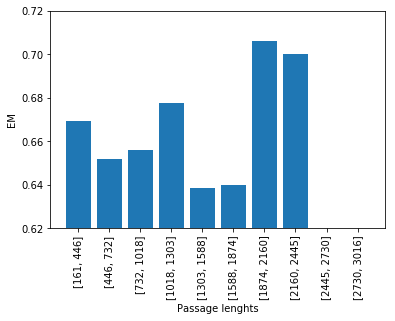

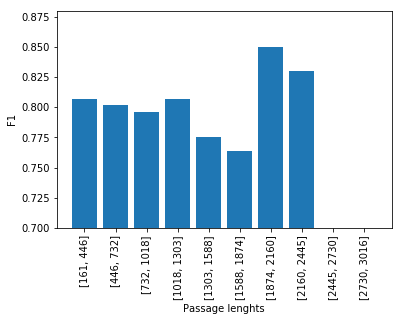

In [ ]:
# passage lenghts
scores_em = []
scores_f1 = []
lenghts = []
for i in free_indices:
    exact_match = metric_max_over_ground_truths(
        exact_match_score, ai_val_preds[i], [validation_dataset[i]['answer']])
    f1 = metric_max_over_ground_truths(
        f1_score,  ai_val_preds[i], [validation_dataset[i]['answer']])
    scores_em.append(exact_match)
    scores_f1.append(f1)
    lenghts.append(len(validation_dataset[i]['passage']))
from scipy import stats
n_bins = 10
import matplotlib.pyplot as plt
y , x, _ = stats.binned_statistic(lenghts, scores_em, 'mean', bins=n_bins)
fig, ax = plt.subplots(1)
plt.bar(list(range(n_bins)),y)

ax.set(ylim=(0.62, 0.72))
plt.xticks(list(range(n_bins)), [f'[{x[i]:.0f}, {x[i+1]:.0f}]' for i in range(n_bins)], rotation="vertical")
plt.ylabel('EM')
plt.xlabel('Passage lenghts')

plt.show()
fig, ax = plt.subplots(1)
y , x, _ = stats.binned_statistic(lenghts, scores_f1, 'mean', bins=n_bins)
plt.bar(list(range(n_bins)),y)
ax.set(ylim=(0.7, 0.88))

plt.xticks(list(range(n_bins)), [f'[{x[i]:.0f}, {x[i+1]:.0f}]' for i in range(n_bins)], rotation="vertical")
plt.ylabel('F1')
plt.xlabel('Passage lenghts')
plt.show()



## Supporting passage lenghts

c:\program files\python36\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
c:\program files\python36\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1996: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


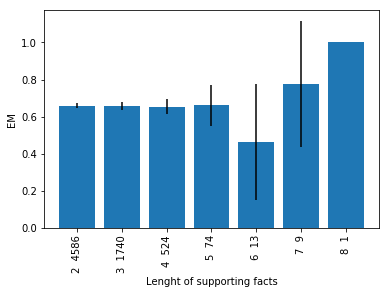

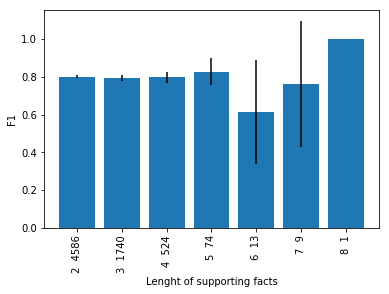

In [ ]:


#Our sentences we like to encode
lenghts = set([len(validation_dataset[i]['supporting_facts']['sent_id']) for i in free_indices])
SUP_FACTS_LEN = len(lenghts)
scores_em = [[] for _ in range(SUP_FACTS_LEN)]
scores_f1 = [[] for _ in range(SUP_FACTS_LEN)]
j = 0
for i in free_indices:
    exact_match = metric_max_over_ground_truths(
        exact_match_score, ai_val_preds[i], [validation_dataset[i]['answer']])
    f1 = metric_max_over_ground_truths(
        f1_score,  ai_val_preds[i], [validation_dataset[i]['answer']])
    cluster_index = len(validation_dataset[i]['supporting_facts']['sent_id']) - min(lenghts)
    scores_em[cluster_index].append(exact_match)
    scores_f1[cluster_index].append(f1)
    j += 1
    
scores_em_avgs = []
scores_f1_avgs = []
scores_em_stds = []
scores_f1_stds = []
for i in range(SUP_FACTS_LEN):
    scores_em_avgs.append(np.average(scores_em[i]))
    scores_f1_avgs.append(np.average(scores_f1[i]))
    interval_em = stats.t.interval(alpha=0.95, df=len(scores_em[i])-1, loc=np.mean(scores_em[i]), scale=st.sem(scores_em[i])) 
    scores_em_stds.append((interval_em[0]-interval_em[1])/2)
    interval_f1 = stats.t.interval(alpha=0.95, df=len(scores_f1[i])-1, loc=np.mean(scores_f1[i]), scale=st.sem(scores_f1[i]))
    scores_f1_stds.append((interval_f1[1]-interval_f1[0])/2)

fig, ax = plt.subplots(1)

plt.bar(list(range(SUP_FACTS_LEN)),scores_em_avgs, yerr=scores_em_stds)

#ax.set(ylim=(0.2, 0.8))
plt.xticks(list(range(SUP_FACTS_LEN)), [f'{i+ min(lenghts)}  {len(scores_f1[i])}' for i in range(SUP_FACTS_LEN)], rotation="vertical")
plt.ylabel('EM')
plt.xlabel('Lenght of supporting facts')

plt.show()
fig, ax = plt.subplots(1)
plt.bar(list(range(SUP_FACTS_LEN)),scores_f1_avgs, yerr=scores_f1_stds)
#ax.set(ylim=(0.4, 0.95))

plt.xticks(list(range(SUP_FACTS_LEN)), [f'{i+ min(lenghts)}  {len(scores_f1[i])}' for i in range(SUP_FACTS_LEN)], rotation="vertical")
plt.ylabel('F1')
plt.xlabel('Lenght of supporting facts')
plt.show()



## LDA topics

In [ ]:
# Learn LDA model on validation dataset
# downloads
spacy.load('en')
parser = English()
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
nltk.download('punkt')
LDA_TOPICS = 10

# see https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
#import pyLDAvis.gensim and https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

def detect_question(token):
    # assume token is string
    tag = nltk.pos_tag([token])
    if tag[0][1] in ["WP", "WRB", "WP$"]:
        return True
    else:
        return False
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 3]
    tokens = [token for token in tokens if (token not in en_stop) or  (detect_question(token))]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

def learn_lda_model(dataset):
    paragraphs = []
    for i in free_indices:
        paragraphs.append(dataset[i]['passage'])

    # prep data
    paragraphs_lda = []
    for i in range(len(paragraphs)):
        paragraphs_lda.append(prepare_text_for_lda(paragraphs[i]))

    dictionary = corpora.Dictionary(paragraphs_lda)
    corpus = [dictionary.doc2bow(text) for text in paragraphs_lda]
    pickle.dump(corpus, open('corpus.pkl', 'wb'))
    dictionary.save('dictionary.gensim')
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = LDA_TOPICS, id2word=dictionary, passes=15)
    ldamodel.save('lda_model_10.gensim')
    topics = ldamodel.print_topics(num_words=10)
    for topic in topics:
        print(topic)

class LDA_model:
    def __init__(self):
        self.n_topics = LDA_TOPICS
        self.model =  models.LdaModel.load('lda_model_10.gensim')
        self.dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
        self.corpus = pickle.load(open('corpus.pkl', 'rb'))
    def predict(self, paragraph):
        paragraph = prepare_text_for_lda(paragraph)
        new_doc_bow = self.dictionary.doc2bow(paragraph)
        result = self.model.get_document_topics(new_doc_bow)
        vector = [0] * self.n_topics
        for top in result:
            vector[top[0]] = top[1]
        return vector
    def show_topics(self):
        topics = self.model.print_topics(num_words=10)
        for topic in topics:
            print(topic)
#learn_lda_model(validation_dataset)
lda_model = LDA_model()



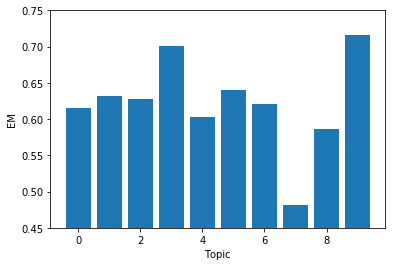

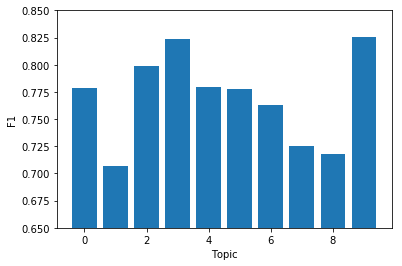

In [ ]:
# LDA differences
scores_em = [[] for _ in range(LDA_TOPICS)]
scores_f1 = [[] for _ in range(LDA_TOPICS)]
for i in free_indices:
    exact_match = metric_max_over_ground_truths(
        exact_match_score, ai_val_preds[i], [validation_dataset[i]['answer']])
    f1 = metric_max_over_ground_truths(
        f1_score,  ai_val_preds[i], [validation_dataset[i]['answer']])
    topics_passage = lda_model.predict(validation_dataset[i]['passage'])
    main_topic = np.argmax(topics_passage)
    scores_em[main_topic].append(exact_match)
    scores_f1[main_topic].append(f1)

scores_em_avgs = []
scores_f1_avgs = []
for i in range(LDA_TOPICS):
    scores_em_avgs.append(np.average(scores_em[i]))
    scores_f1_avgs.append(np.average(scores_f1[i]))
fig, ax = plt.subplots(1)

plt.bar(list(range(LDA_TOPICS)),scores_em_avgs)

ax.set(ylim=(0.45, 0.75))
#plt.xticks(list(range(LDA_TOPICS)), [f'[{x[i]:.0f}, {x[i+1]:.0f}]' for i in range(LDA_TOPICS)], rotation="vertical")
plt.ylabel('EM')
plt.xlabel('Topic')

plt.show()
fig, ax = plt.subplots(1)
plt.bar(list(range(LDA_TOPICS)),scores_f1_avgs)
ax.set(ylim=(0.65, 0.85))

#plt.xticks(list(range(LDA_TOPICS)), [f'[{x[i]:.0f}, {x[i+1]:.0f}]' for i in range(LDA_TOPICS)], rotation="vertical")
plt.ylabel('F1')
plt.xlabel('Topic')
plt.show()


## Question Classification

In [ ]:

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

def detect_question(token):
    # assume token is string
    tag = nltk.pos_tag([token])
    if tag[0][1] in ["WP", "WRB", "WP$"]:
        return True
    else:
        return False

question_words = ["what", "when", "where", "which", "who", "whom", "whose", "why", "how"]

def question_classification(question):
    question_vec = [0] * len(question_words)
    tokens = tokenize(question)
    tokens = [get_lemma(token) for token in tokens]
    all_zero = True
    for token in tokens:
        for i in range(len(question_words)):
            if token == question_words[i]:
                question_vec[i] = 1
                all_zero = False
    #if all_zero:
    #    print(f' question: {question}')
    return question_vec, all_zero


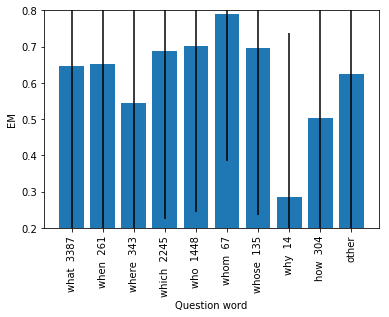

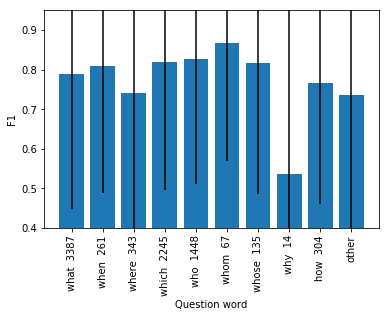

In [ ]:
# question differences
QUESTION_WORDS = len(question_words) + 1 
scores_em = [[] for _ in range(QUESTION_WORDS)]
scores_f1 = [[] for _ in range(QUESTION_WORDS)]
for i in free_indices:
    exact_match = metric_max_over_ground_truths(
        exact_match_score, ai_val_preds[i], [validation_dataset[i]['answer']])
    f1 = metric_max_over_ground_truths(
        f1_score,  ai_val_preds[i], [validation_dataset[i]['answer']])
    question_word, all_zero = question_classification(validation_dataset[i]['question'])
    if all_zero:
        scores_em[-1].append(exact_match)
        scores_f1[-1].append(f1)
    else:
        for j in range(QUESTION_WORDS-1):
            if question_word[j] == 1:
                scores_em[j].append(exact_match)
                scores_f1[j].append(f1)

scores_em_avgs = []
scores_f1_avgs = []
scores_em_stds = []
scores_f1_stds = []
for i in range(QUESTION_WORDS):
    scores_em_avgs.append(np.average(scores_em[i]))
    scores_f1_avgs.append(np.average(scores_f1[i]))
    scores_em_stds.append(np.std(scores_em[i]))
    scores_f1_stds.append(np.std(scores_f1[i]))

fig, ax = plt.subplots(1)

plt.bar(list(range(QUESTION_WORDS)),scores_em_avgs, yerr=scores_em_stds)

ax.set(ylim=(0.2, 0.8))
plt.xticks(list(range(QUESTION_WORDS)), [f'{question_words[i]}  {len(scores_f1[i])}' for i in range(QUESTION_WORDS-1)]+["other"], rotation="vertical")
plt.ylabel('EM')
plt.xlabel('Question word')

plt.show()
fig, ax = plt.subplots(1)
plt.bar(list(range(QUESTION_WORDS)),scores_f1_avgs, yerr=scores_f1_stds)
ax.set(ylim=(0.4, 0.95))

plt.xticks(list(range(QUESTION_WORDS)), [f'{question_words[i]}  {len(scores_f1[i])}' for i in range(QUESTION_WORDS-1)]+["other"], rotation="vertical")
plt.ylabel('F1')
plt.xlabel('Question word')
plt.show()



## Model embeddings clustering
- average embeddings from model
- embeddings from questions, sentence embeddings
- embeddings from passages
- embeddings from answers
compare both k-means and k-medoids
```{toggle}

```


### Average from QA model

inertia is 38060.919


c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\program files\python36\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
c:\program files\python36\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\program files\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1996: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


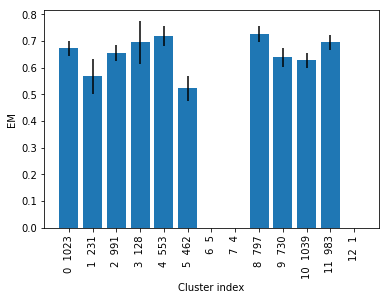

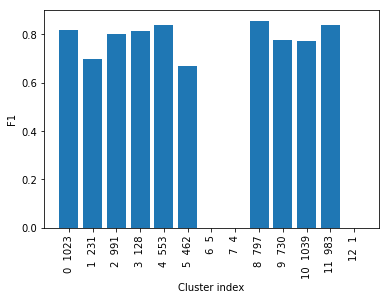

In [ ]:
# question differences
from sklearn.cluster import KMeans
import pickle
with open('C:/Users/Hussein/Documents/Research/Human learn to defer/hotpotqa/dev set preds/embeddings_data_val.p', 'rb') as handle:
    embeddings_val = pickle.load(handle)

embeddings_val = [embeddings_val[i][1] for i in range(len(embeddings_val))]
embeddings_val = np.asarray(embeddings_val)
teaching_embeddings = embeddings_val[:START_TEST]
validation_embeddings = embeddings_val[START_TEST:]


N_CLUSTERS = 13
kmeans = KMeans(n_clusters=N_CLUSTERS).fit(embeddings_val)
print(f'inertia is {kmeans.inertia_:.3f}')
scores_em = [[] for _ in range(N_CLUSTERS)]
scores_f1 = [[] for _ in range(N_CLUSTERS)]
for i in free_indices:
    exact_match = metric_max_over_ground_truths(
        exact_match_score, ai_val_preds[i], [validation_dataset[i]['answer']])
    f1 = metric_max_over_ground_truths(
        f1_score,  ai_val_preds[i], [validation_dataset[i]['answer']])
    cluster_index = kmeans.labels_[i]
    scores_em[cluster_index].append(exact_match)
    scores_f1[cluster_index].append(f1)

scores_em_avgs = []
scores_f1_avgs = []
scores_em_stds = []
scores_f1_stds = []
for i in range(N_CLUSTERS):
    scores_em_avgs.append(np.average(scores_em[i]))
    scores_f1_avgs.append(np.average(scores_f1[i]))
    interval_em = stats.t.interval(alpha=0.95, df=len(scores_em[i])-1, loc=np.mean(scores_em[i]), scale=st.sem(scores_em[i])) 
    scores_em_stds.append((interval_em[0]-interval_em[1])/2)
    interval_f1 = stats.t.interval(alpha=0.95, df=len(scores_f1[i])-1, loc=np.mean(scores_f1[i]), scale=st.sem(scores_f1[i]))
    scores_f1_stds.append((interval_em[1]-interval_em[1])/2)

fig, ax = plt.subplots(1)

plt.bar(list(range(N_CLUSTERS)),scores_em_avgs, yerr=scores_em_stds)

#ax.set(ylim=(0.2, 0.8))
plt.xticks(list(range(N_CLUSTERS)), [f'{i}  {len(scores_f1[i])}' for i in range(N_CLUSTERS)], rotation="vertical")
plt.ylabel('EM')
plt.xlabel('Cluster index')

plt.show()
fig, ax = plt.subplots(1)
plt.bar(list(range(N_CLUSTERS)),scores_f1_avgs, yerr=scores_f1_stds)
#ax.set(ylim=(0.4, 0.95))

plt.xticks(list(range(N_CLUSTERS)), [f'{i}  {len(scores_f1[i])}' for i in range(N_CLUSTERS)], rotation="vertical")
plt.ylabel('F1')
plt.xlabel('Cluster index')
plt.show()



### Embedding Passage

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')



inertia is 704937.763


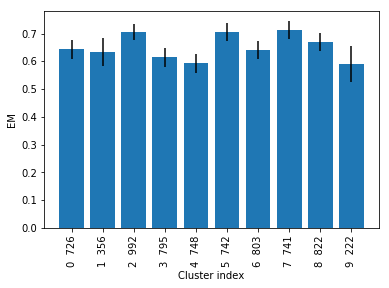

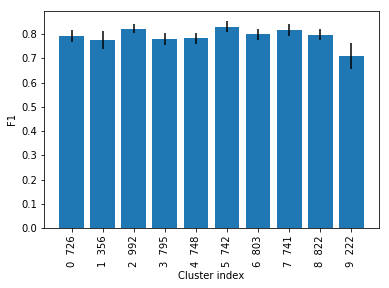

In [ ]:


#Our sentences we like to encode
#Our sentences we like to encode
all_passages = [validation_dataset[i]['passage'] for i in free_indices]

#Sentences are encoded by calling model.encode()
embeddings_passage = model.encode(all_passages)

N_CLUSTERS = 10
kmeans = KMeans(n_clusters=N_CLUSTERS,max_iter = 10000).fit(embeddings_passage)
print(f'inertia is {kmeans.inertia_:.3f}')
scores_em = [[] for _ in range(N_CLUSTERS)]
scores_f1 = [[] for _ in range(N_CLUSTERS)]
j = 0
for i in free_indices:
    exact_match = metric_max_over_ground_truths(
        exact_match_score, ai_val_preds[i], [validation_dataset[i]['answer']])
    f1 = metric_max_over_ground_truths(
        f1_score,  ai_val_preds[i], [validation_dataset[i]['answer']])
    cluster_index = kmeans.labels_[j]
    scores_em[cluster_index].append(exact_match)
    scores_f1[cluster_index].append(f1)
    j += 1
    
scores_em_avgs = []
scores_f1_avgs = []
scores_em_stds = []
scores_f1_stds = []
for i in range(N_CLUSTERS):
    scores_em_avgs.append(np.average(scores_em[i]))
    scores_f1_avgs.append(np.average(scores_f1[i]))
    interval_em = stats.t.interval(alpha=0.95, df=len(scores_em[i])-1, loc=np.mean(scores_em[i]), scale=st.sem(scores_em[i])) 
    scores_em_stds.append((interval_em[0]-interval_em[1])/2)
    interval_f1 = stats.t.interval(alpha=0.95, df=len(scores_f1[i])-1, loc=np.mean(scores_f1[i]), scale=st.sem(scores_f1[i]))
    scores_f1_stds.append((interval_f1[1]-interval_f1[0])/2)

fig, ax = plt.subplots(1)

plt.bar(list(range(N_CLUSTERS)),scores_em_avgs, yerr=scores_em_stds)

#ax.set(ylim=(0.2, 0.8))
plt.xticks(list(range(N_CLUSTERS)), [f'{i}  {len(scores_f1[i])}' for i in range(N_CLUSTERS)], rotation="vertical")
plt.ylabel('EM')
plt.xlabel('Cluster index')

plt.show()
fig, ax = plt.subplots(1)
plt.bar(list(range(N_CLUSTERS)),scores_f1_avgs, yerr=scores_f1_stds)
#ax.set(ylim=(0.4, 0.95))

plt.xticks(list(range(N_CLUSTERS)), [f'{i}  {len(scores_f1[i])}' for i in range(N_CLUSTERS)], rotation="vertical")
plt.ylabel('F1')
plt.xlabel('Cluster index')
plt.show()



### Embedding Question

inertia is 978195.360


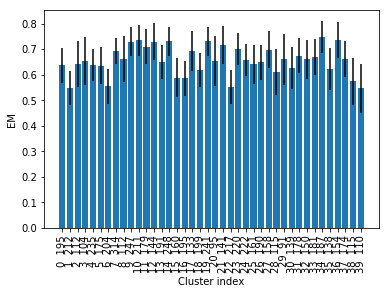

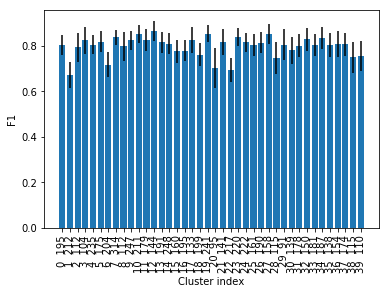

In [ ]:

#Our sentences we like to encode
all_passages = [validation_dataset[i]['question'] for i in free_indices]

#Sentences are encoded by calling model.encode()
embeddings_passage = model.encode(all_passages)

N_CLUSTERS = 40
kmeans = KMeans(n_clusters=N_CLUSTERS,max_iter = 10000).fit(embeddings_passage)
print(f'inertia is {kmeans.inertia_:.3f}')
scores_em = [[] for _ in range(N_CLUSTERS)]
scores_f1 = [[] for _ in range(N_CLUSTERS)]
j = 0
for i in free_indices:
    exact_match = metric_max_over_ground_truths(
        exact_match_score, ai_val_preds[i], [validation_dataset[i]['answer']])
    f1 = metric_max_over_ground_truths(
        f1_score,  ai_val_preds[i], [validation_dataset[i]['answer']])
    cluster_index = kmeans.labels_[j]
    scores_em[cluster_index].append(exact_match)
    scores_f1[cluster_index].append(f1)
    j += 1
scores_em_avgs = []
scores_f1_avgs = []
scores_em_stds = []
scores_f1_stds = []
for i in range(N_CLUSTERS):
    scores_em_avgs.append(np.average(scores_em[i]))
    scores_f1_avgs.append(np.average(scores_f1[i]))
    interval_em = stats.t.interval(alpha=0.95, df=len(scores_em[i])-1, loc=np.mean(scores_em[i]), scale=st.sem(scores_em[i])) 
    scores_em_stds.append((interval_em[0]-interval_em[1])/2)
    interval_f1 = stats.t.interval(alpha=0.95, df=len(scores_f1[i])-1, loc=np.mean(scores_f1[i]), scale=st.sem(scores_f1[i]))
    scores_f1_stds.append((interval_f1[1]-interval_f1[0])/2)

fig, ax = plt.subplots(1)

plt.bar(list(range(N_CLUSTERS)),scores_em_avgs, yerr=scores_em_stds)

#ax.set(ylim=(0.2, 0.8))
plt.xticks(list(range(N_CLUSTERS)), [f'{i}  {len(scores_f1[i])}' for i in range(N_CLUSTERS)], rotation="vertical")
plt.ylabel('EM')
plt.xlabel('Cluster index')

plt.show()
fig, ax = plt.subplots(1)
plt.bar(list(range(N_CLUSTERS)),scores_f1_avgs, yerr=scores_f1_stds)
#ax.set(ylim=(0.4, 0.95))

plt.xticks(list(range(N_CLUSTERS)), [f'{i}  {len(scores_f1[i])}' for i in range(N_CLUSTERS)], rotation="vertical")
plt.ylabel('F1')
plt.xlabel('Cluster index')
plt.show()



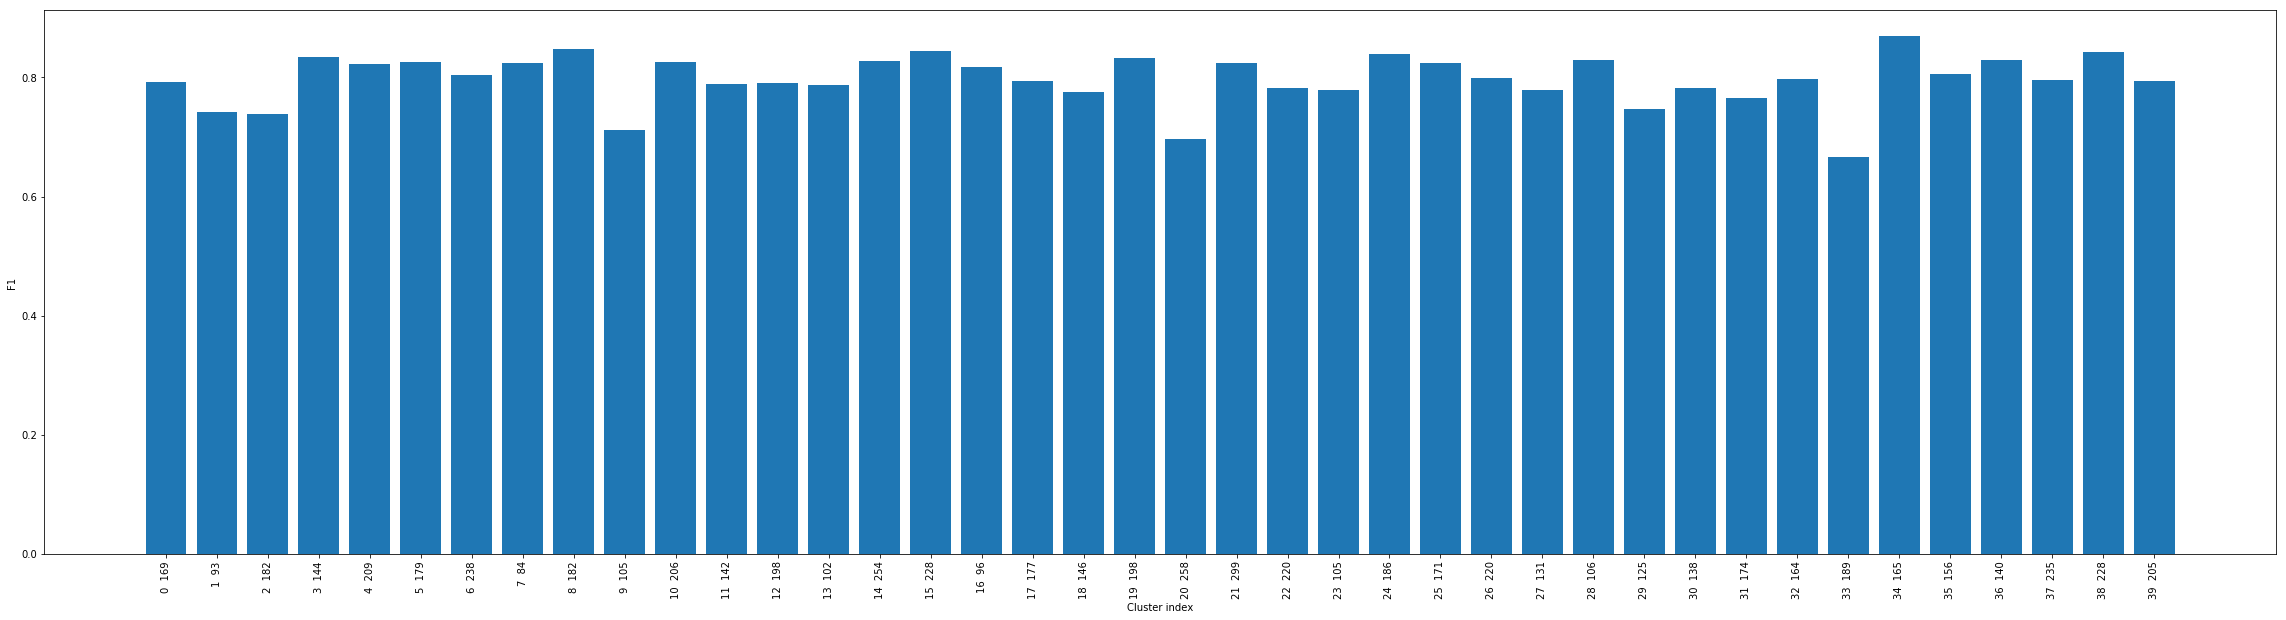

In [ ]:
plt.figure(figsize=(40,10))
plt.bar(list(range(N_CLUSTERS)),scores_f1_avgs, yerr=scores_f1_stds)
#ax.set(ylim=(0.4, 0.95))

plt.xticks(list(range(N_CLUSTERS)), [f'{i}  {len(scores_f1[i])}' for i in range(N_CLUSTERS)], rotation="vertical")
plt.ylabel('F1')
plt.xlabel('Cluster index')
plt.show()


In [ ]:
j = 0
for i in free_indices:
    
    cluster_index = kmeans.labels_[j]
    if cluster_index == 12:
        print(validation_dataset[i]['question'])
    j += 1

### Embedding Answer

inertia is 1216608.815


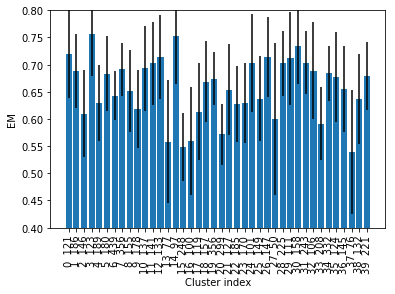

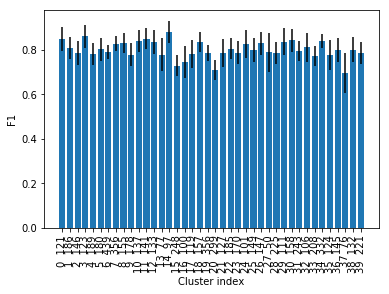

In [ ]:

#Our sentences we like to encode
all_passages = [validation_dataset[i]['answer'] for i in free_indices]

#Sentences are encoded by calling model.encode()
embeddings_passage = model.encode(all_passages)

N_CLUSTERS = 40
kmeans = KMeans(n_clusters=N_CLUSTERS,max_iter = 10000).fit(embeddings_passage)
print(f'inertia is {kmeans.inertia_:.3f}')
scores_em = [[] for _ in range(N_CLUSTERS)]
scores_f1 = [[] for _ in range(N_CLUSTERS)]
j = 0
for i in free_indices:
    exact_match = metric_max_over_ground_truths(
        exact_match_score, ai_val_preds[i], [validation_dataset[i]['answer']])
    f1 = metric_max_over_ground_truths(
        f1_score,  ai_val_preds[i], [validation_dataset[i]['answer']])
    cluster_index = kmeans.labels_[j]
    scores_em[cluster_index].append(exact_match)
    scores_f1[cluster_index].append(f1)
    j += 1
scores_em_avgs = []
scores_f1_avgs = []
scores_em_stds = []
scores_f1_stds = []
for i in range(N_CLUSTERS):
    scores_em_avgs.append(np.average(scores_em[i]))
    scores_f1_avgs.append(np.average(scores_f1[i]))
    interval_em = stats.t.interval(alpha=0.95, df=len(scores_em[i])-1, loc=np.mean(scores_em[i]), scale=st.sem(scores_em[i])) 
    scores_em_stds.append((interval_em[1]-interval_em[0])/2)
    interval_f1 = stats.t.interval(alpha=0.95, df=len(scores_f1[i])-1, loc=np.mean(scores_f1[i]), scale=st.sem(scores_f1[i]))
    scores_f1_stds.append((interval_f1[1]-interval_f1[0])/2)

fig, ax = plt.subplots(1)

plt.bar(list(range(N_CLUSTERS)),scores_em_avgs, yerr=scores_em_stds)

ax.set(ylim=(0.4, 0.8))
plt.xticks(list(range(N_CLUSTERS)), [f'{i}  {len(scores_f1[i])}' for i in range(N_CLUSTERS)], rotation="vertical")
plt.ylabel('EM')
plt.xlabel('Cluster index')

plt.show()
fig, ax = plt.subplots(1)
plt.bar(list(range(N_CLUSTERS)),scores_f1_avgs, yerr=scores_f1_stds)
#ax.set(ylim=(0.4, 0.95))

plt.xticks(list(range(N_CLUSTERS)), [f'{i}  {len(scores_f1[i])}' for i in range(N_CLUSTERS)], rotation="vertical")
plt.ylabel('F1')
plt.xlabel('Cluster index')
plt.show()



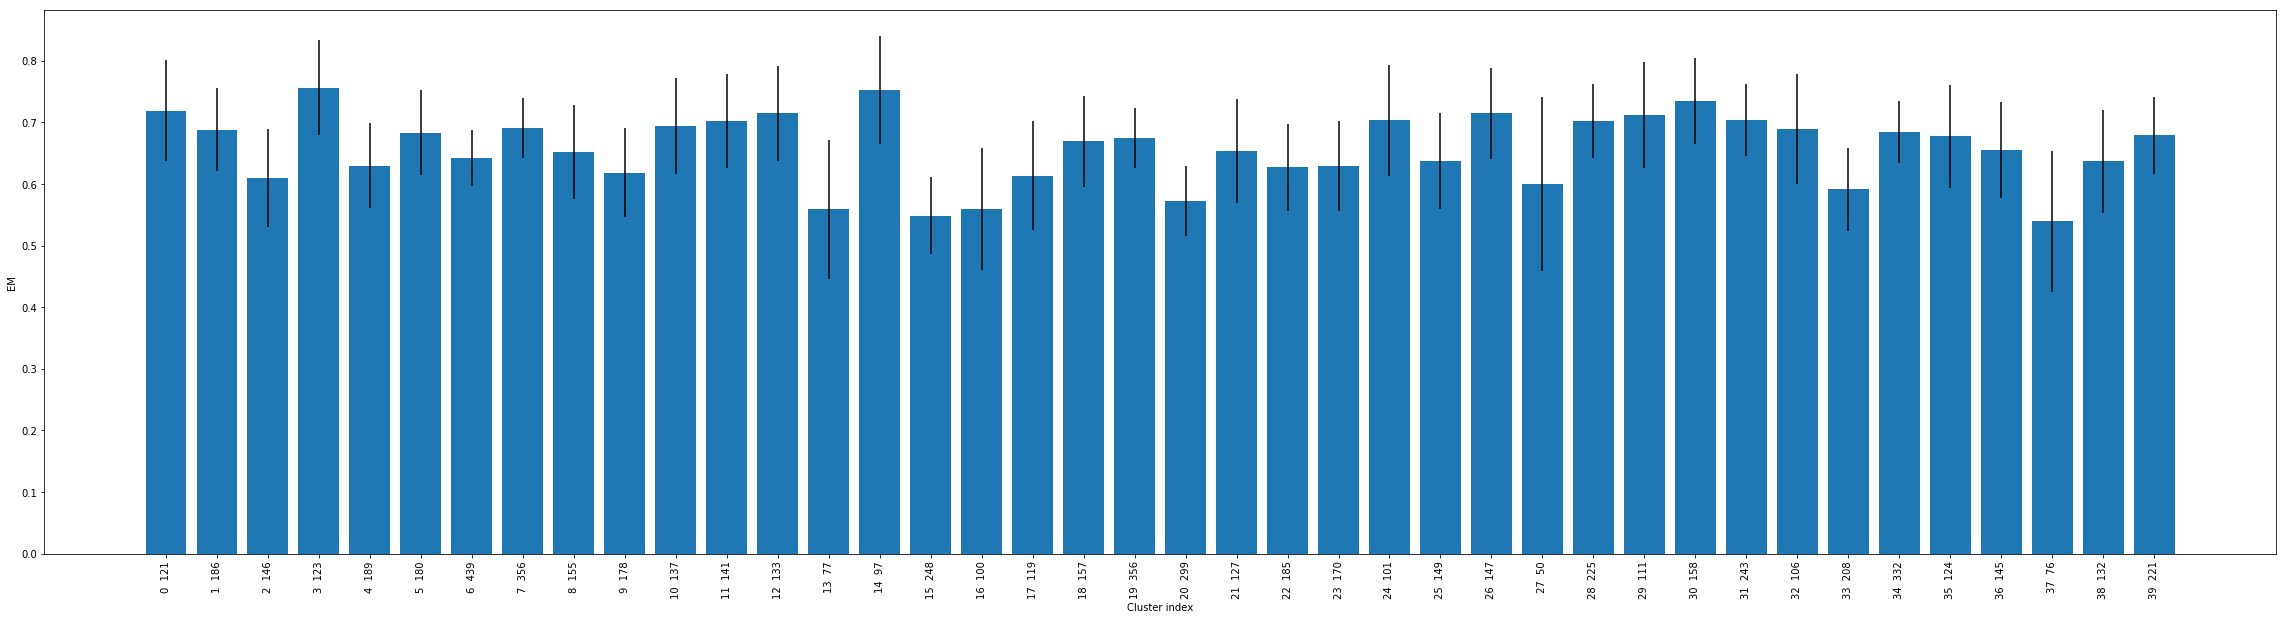

In [ ]:
plt.figure(figsize=(40,10))
plt.bar(list(range(N_CLUSTERS)),scores_em_avgs, yerr=scores_em_stds)

ax.set(ylim=(0.4, 0.8))
plt.xticks(list(range(N_CLUSTERS)), [f'{i}  {len(scores_f1[i])}' for i in range(N_CLUSTERS)], rotation="vertical")
plt.ylabel('EM')
plt.xlabel('Cluster index')


# Classifier to predict mistakes
Build classifier based on concatenated embeddings of passage, question and AI prediction, predicts If EM=1 or not.

In [ ]:
#Our sentences we like to encode
all_passages = [validation_dataset[i]['passage'] for i in free_indices]
all_questions = [validation_dataset[i]['question'] for i in free_indices]
all_aipreds = [ai_val_preds[i] for i in free_indices]
#Sentences are encoded by calling model.encode()
embeddings_passage = model.encode(all_passages)
embeddings_question = model.encode(all_questions)
embeddings_preds = model.encode(all_aipreds)
embeddings = np.asarray([np.concatenate([embeddings_passage[i],embeddings_question[i],embeddings_preds[i]]) for i in range(len(embeddings_passage))])

In [ ]:
# Optimal deferall decisions
labels_ai = []
all_answers = [validation_dataset[i]['answer'] for i in free_indices]

for i in range(len(all_answers)):
    f1_ai = metric_max_over_ground_truths(f1_score,all_answers[i], [all_aipreds[i]])
    if f1_ai <0.5:
        labels_ai.append(1)
    else:
        labels_ai.append(0)
labels_ai = np.asarray(labels_ai)

In [ ]:
np.sum(labels_ai)

1116

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
X_pca = pca.fit_transform(embeddings)
print(pca.explained_variance_ratio_)

In [ ]:
print(pca.explained_variance_ratio_)

[0.02528435 0.02049066 0.01858797 0.01745798 0.01689854 0.01553007
 0.01413696 0.01324355 0.01246825 0.01204482 0.01192152 0.01153637
 0.01135136 0.01062    0.01047625 0.00988718 0.00983088 0.00942216
 0.00914036 0.00902137 0.00878497 0.00828741 0.00813444 0.00795826
 0.00784004 0.00757303 0.00750739 0.00724167 0.00713977 0.00701642]


In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


names = ["Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
    "QDA"]

classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    QuadraticDiscriminantAnalysis()]


# preprocess dataset, split into training and test part
X = X_pca
y = labels_ai
#X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.3, random_state=42)

print("Starting classifcation")
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(f'score for {name} is {score:.3f}')


Starting classifcation
score for Linear SVM is 0.616
score for RBF SVM is 0.654
score for Decision Tree is 0.604
score for Random Forest is 0.650
score for Neural Net is 0.609
score for AdaBoost is 0.617
score for QDA is 0.655


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

model_class = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [ ]:
all_passages = []
all_questions = 
all_aipreds = []
labels = []
inputs = []

In [ ]:
train_encodings = tokenizer(train_questions, train_contexts,  truncation=True, padding=True, return_tensors="pt")
trainval_encodings = tokenizer(trainval_questions, trainval_contexts,  truncation=True, padding=True, return_tensors="pt")
val_encodings = tokenizer(val_questions, val_contexts, truncation=True, padding=True)
val_ans_encodings = tokenizer([val_answers[i]['text'] for i in range(len(val_answers))])
train_ans_encodings = tokenizer([train_answers[i]['text'] for i in range(len(train_answers))])
trainval_ans_encodings = tokenizer([trainval_answers[i]['text'] for i in range(len(trainval_answers))])

In [ ]:
import torch
train_encodings = tokenizer(train_questions, train_contexts,  truncation=True, padding=True, return_tensors="pt")
trainval_encodings = tokenizer(trainval_questions, trainval_contexts,  truncation=True, padding=True, return_tensors="pt")
val_encodings = tokenizer(val_questions, val_contexts, truncation=True, padding=True)
val_ans_encodings = tokenizer([val_answers[i]['text'] for i in range(len(val_answers))])
train_ans_encodings = tokenizer([train_answers[i]['text'] for i in range(len(train_answers))])
trainval_ans_encodings = tokenizer([trainval_answers[i]['text'] for i in range(len(trainval_answers))])
class HotpotDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)
BATCH_SIZE = 8
train_dataset = HotpotDataset(train_encodings)
trainval_dataset = HotpotDataset(trainval_encodings)
val_dataset = HotpotDataset(val_encodings)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
trainval_loader = DataLoader(trainval_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
from transformers import get_linear_schedule_with_warmup
n_epochs = 4
model.train()
optimizer = AdamW(model.parameters(), lr=3e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 1000, len(train_questions)*n_epochs/BATCH_SIZE)

from tqdm import tqdm
my_list = list(range(len(train_questions)*n_epochs))
with tqdm(total=len(my_list)) as pbar:
    for epoch in range(n_epochs):
        print("####################")
        print("New epoch")
        print("####################")
        model.eval()
        model_evaluation(model, tokenizer, trainval_questions, trainval_contexts, trainval_answers)
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            answer_start_scores = outputs['start_logits'][0]
            answer_end_scores = outputs['end_logits'][0]
            answer_start = torch.argmax(answer_start_scores)  # get the most likely beginning of answer with the argmax of the score
            answer_end = torch.argmax(answer_end_scores) + 1  # get the most likely end of answer with the argmax of the score
            loss = outputs[0]
            loss.backward()
            optimizer.step()
            scheduler.step()
            pbar.update(BATCH_SIZE)
model.eval()
model_evaluation(model, tokenizer, trainval_questions, trainval_contexts, trainval_answers)
#model.eval()

# Bag of words classifier

In [ ]:
y = labels_ai
X = [ all_questions[i]  for i in range(len(all_passages))]
#X = [all_passages[i] +" "+ all_questions[i] +" "+ all_aipreds[i] for i in range(len(all_passages))]

In [ ]:
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    #document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [ ]:
documents[0:4]

['what government position wa held by the woman who portrayed corliss archer in the film kiss and tell',
 'what science fantasy young adult series told in first person ha a set of companion book narrating the story of enslaved world and alien specie',
 'the director of the romantic comedy big stone gap is based in what new york city',
 '2014 s s is the debut album of a south korean boy group that wa formed by who']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

vectorizer = CountVectorizer(max_features=1500)
X = vectorizer.fit_transform(documents).toarray()

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [ ]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(documents).toarray()
'''

"\nfrom sklearn.feature_extraction.text import TfidfVectorizer\ntfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))\nX = tfidfconverter.fit_transform(documents).toarray()\n"

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = SVC()
classifier.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = classifier.predict(X_test)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[1159    0]
 [ 231    0]]


c:\program files\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1159
           1       0.00      0.00      0.00       231

    accuracy                           0.83      1390
   macro avg       0.42      0.50      0.45      1390
weighted avg       0.70      0.83      0.76      1390

0.8338129496402877


# Bert

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [ ]:
all_passages = [validation_dataset[i]['passage'] for i in free_indices]
all_questions = [validation_dataset[i]['question'] for i in free_indices]
all_aipreds = [ai_val_preds[i] for i in free_indices]

In [ ]:
# Optimal deferall decisions
labels_ai = []
all_answers = [validation_dataset[i]['answer'] for i in free_indices]

for i in range(len(all_answers)):
    f1_ai = metric_max_over_ground_truths(exact_match_score, all_answers[i], [all_aipreds[i]])
    if f1_ai <0.5:
        labels_ai.append(1)
    else:
        labels_ai.append(0)
labels_ai = np.asarray(labels_ai)

In [ ]:
inputs_hotpot = [all_passages[i] +" "+ all_questions[i]  for i in range(len(all_passages))]
#inputs_hotpot = [all_questions[i] +" "+ all_aipreds[i] for i in range(len(all_passages))]

In [ ]:
VAL_START = math.floor(len(inputs_hotpot)/2)
train_encodings = tokenizer(inputs_hotpot[:VAL_START],  truncation=True, padding=True, return_tensors="pt")
val_encodings = tokenizer(inputs_hotpot[VAL_START:], truncation=True, padding=True)

In [ ]:
train_encodings['label'] = labels_ai[:VAL_START]
val_encodings['label'] = labels_ai[VAL_START:]

In [ ]:
class HotpotDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)
BATCH_SIZE = 16
train_dataset = HotpotDataset(train_encodings)
val_dataset = HotpotDataset(val_encodings)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=100,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=8,
    evaluation_strategy = "epoch",
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [ ]:
plt.hist()

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,No log,0.672348,0.647381,0.000000,0.000000,0.000000,31.341400,110.844000
2,No log,0.655651,0.647381,0.000000,0.000000,0.000000,31.340900,110.846000
3,0.632100,0.673157,0.638745,0.108031,0.417582,0.062041,31.341600,110.843000
4,0.632100,0.848689,0.585780,0.400666,0.409014,0.392653,31.341500,110.843000
5,0.421900,1.530897,0.570236,0.402561,0.394819,0.410612,31.340700,110.846000
6,0.421900,1.922340,0.592689,0.286435,0.374670,0.231837,31.342500,110.840000
7,0.109200,2.291623,0.615429,0.209467,0.380645,0.144490,31.341100,110.845000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

KeyboardInterrupt: ignored

In [ ]:
trainer.evaluate()

{'epoch': 10.0,
 'eval_accuracy': 0.8019573978123201,
 'eval_f1': 0.1291139240506329,
 'eval_loss': 1.766174554824829,
 'eval_precision': 0.23394495412844038,
 'eval_recall': 0.08916083916083917,
 'total_flos': 1505739157536240}

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir logs

In [ ]:


class HotpotDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)
BATCH_SIZE = 8
train_dataset = HotpotDataset(train_encodings)
trainval_dataset = HotpotDataset(trainval_encodings)
val_dataset = HotpotDataset(val_encodings)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
trainval_loader = DataLoader(trainval_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
